# Problem Statement

Nothing is more comforting than being greeted by your favorite drink just as you walk through the door of the corner café. While a thoughtful barista knows you take a macchiato every Wednesday morning at 8:15, it’s much more difficult in a digital space for your preferred brands to personalize your experience.

TalkingData, China’s largest third-party mobile data platform, understands that everyday choices and behaviors paint a picture of who we are and what we value. Currently, TalkingData is seeking to leverage behavioral data from more than 70% of the 500 million mobile devices active daily in China to help its clients better understand and interact with their audiences.

In this notebook we will build a model to predict users’ demographic characteristics based on their app usage, geolocation, and mobile device properties. Doing so will help millions of developers and brand advertisers around the world pursue data-driven marketing efforts which are relevant to their users and catered to their preferences.

# Metrics 

1. Can we predict the demographics of a user (gender and age) based on their app download and usage behaviors?
2. Can we predict 
2. group by each attribute like latitude/longitude, age, is_installed, device_model, phone_brand, category
3. lat/lng by app_ids
4. group mobile devices to lat/lng for households

------------------------
Multi-Class Classification

5. Predict how likely they are to use a type category of app, based their gender, 
- Y features
    - category of app
- X features
    - latitude
    - longitude
    - age
    - gender
    - phone
    - phone model
    - time of day
    
--------------------    
- Y features
 - age and gender 
- X features
    - app
    - latitude
    - longitude
    - phone
    - phone model
    - time of day

- how many mobile apps are on our platform, that have >= 70 paid impressions in last 10 days
- feature selection
- attribute selection


- Recommender System

# Data

The data schema can be represented in the following chart:

File descriptions

- gender_age_train.csv, gender_age_test.csv - the training and test set
- group: this is the target variable you are going to predict
- events.csv, app_events.csv - when a user uses TalkingData SDK, the event gets logged in this data. Each event has an event id, location (lat/long), and the event corresponds to a list of apps in app_events.
- timestamp: when the user is using an app with TalkingData SDK
- app_labels.csv - apps and their labels, the label_id's can be used to join with label_categories
- label_categories.csv - apps' labels and their categories in text
- phone_brand_device_model.csv - device ids, brand, and models
- phone_brand: note that the brands are in Chinese (translation courtesy of user fromandto) 
    - 三星 samsung
    - 天语 Ktouch
    - 海信 hisense
    - 联想 lenovo
    - 欧比 obi
    - ...
- sample_submission.csv - a sample submission file in the correct format

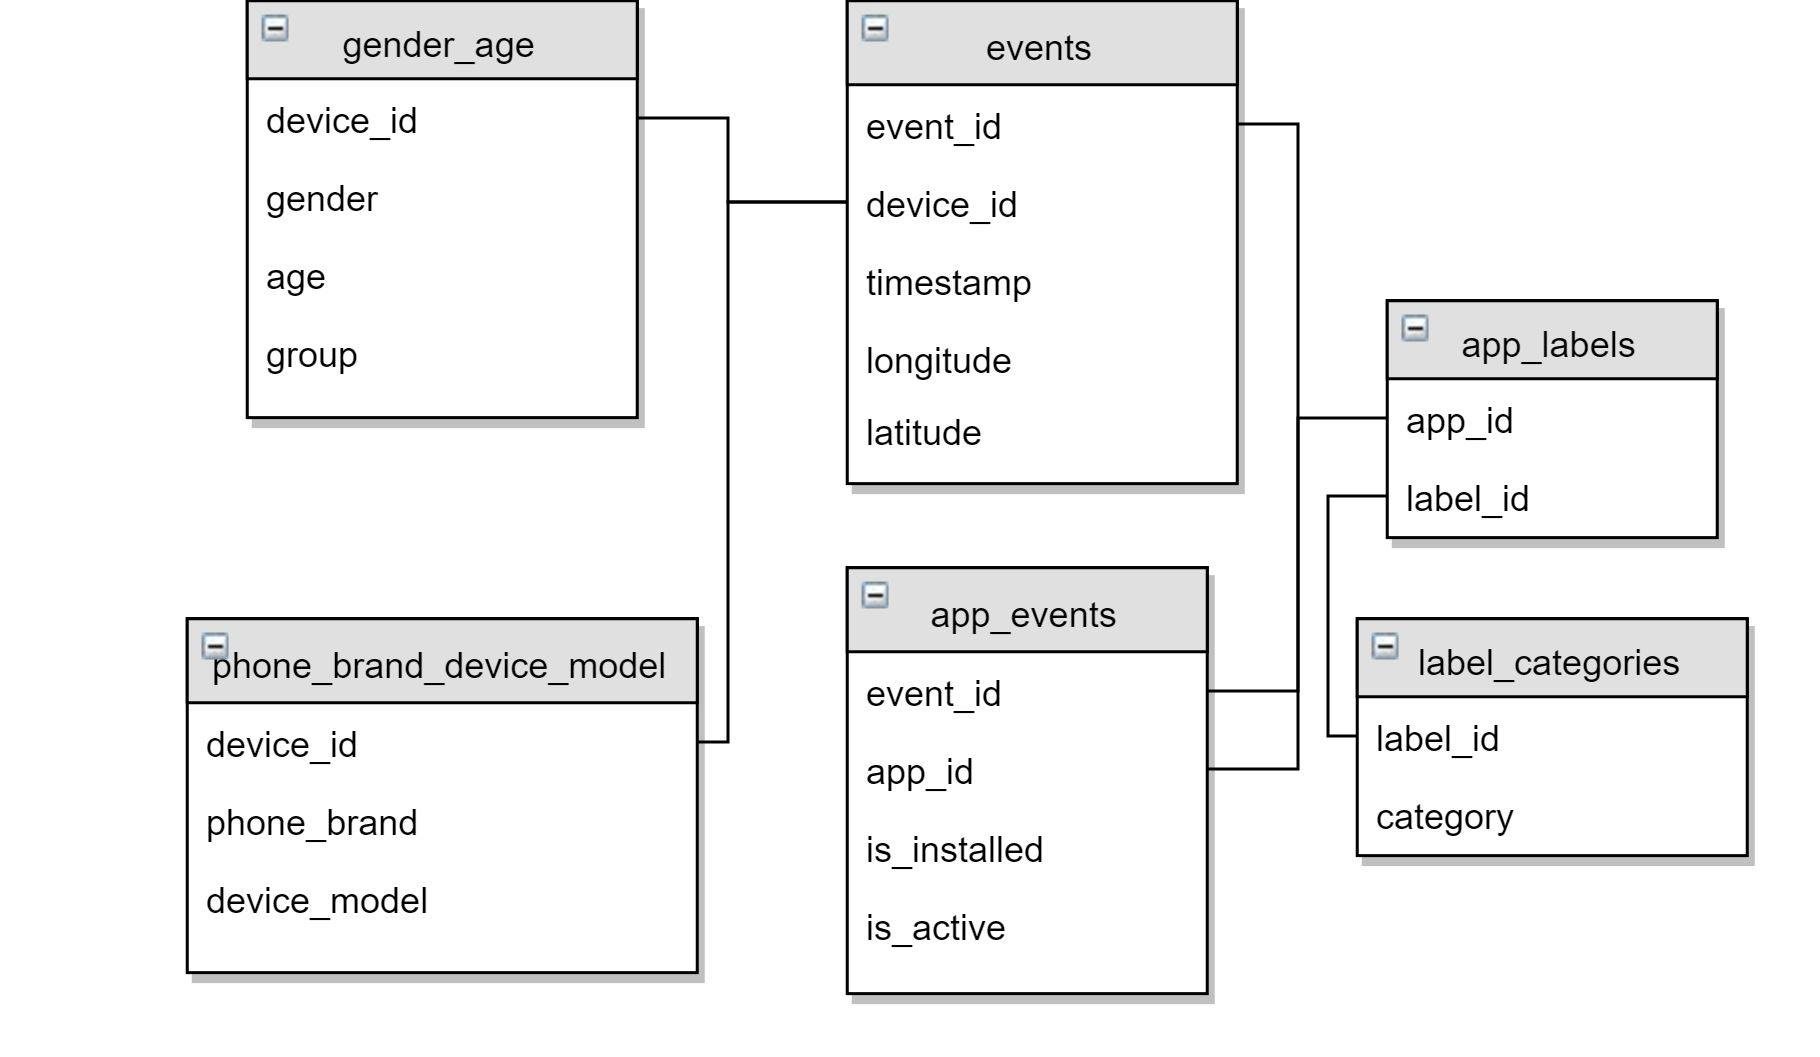

In [1]:
from IPython.display import Image
Image(filename='RelationalDatabasesFlow.jpg')

In [2]:
import os
import pyspark.mllib
import numpy as np
import matplotlib.pyplot
import seaborn as sns
import pyspark
import urllib

from pyspark import SparkConf, SparkContext
from pyspark.sql import SQLContext, SparkSession, Row
from pyspark.sql.types import *
from pyspark.sql.functions import *
# import pyspark.sql.functions as func
from pyspark.ml.feature import OneHotEncoder, StringIndexer
from pyspark.mllib.regression import LinearRegressionWithSGD
from pyspark.mllib.regression import LabeledPoint
from pyspark.mllib.tree import DecisionTree
from IPython.display import display, HTML

get_ipython().magic(u'pylab inline')

/usr/local/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python2.7/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['rand', 'cbrt', 'rank', 'cosh', 'hypot', 'array', 'tan', 'size', 'isnan', 'randn', 'log', 'floor', 'sum', 'sqrt', 'degrees', 'split', 'rint', 'log10', 'sin', 'repeat', 'log2', 'cos', 'ceil', 'broadcast', 'sinh', 'trunc', 'expm1', 'tanh', 'radians', 'exp', 'log1p', 'mean']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [3]:
### Initialize streaming context
conf = SparkConf()\
                .setMaster("local[2]")\
                .setAppName("MobileAnalytics")\
                .set("spark.executor.memory", "4g")\
                .set("spark.driver.memory", "4g")
sc = SparkContext(conf=conf)
sc.setLogLevel("ERROR")
sqlContext = SQLContext(sc)
spark = SparkSession.builder.appName("spark play").getOrCreate()

In [4]:
# train = spark.read.csv("data/gender_age_train.csv", header=True, mode="DROPMALFORMED", inferSchema='true')
# test = spark.read.csv("data/gender_age_test.csv", header=True, mode="DROPMALFORMED", inferSchema='true')
# events = spark.read.csv("data/events.csv", header=True, mode="DROPMALFORMED", inferSchema='true')
# label_categories = spark.read.csv("data/label_categories.csv", header=True, mode="DROPMALFORMED", inferSchema='true')
# phone = spark.read.csv("data/phone_brand_device_model.csv", header=True, mode="DROPMALFORMED", inferSchema='true')
# phone = phone.dropDuplicates() # Drop the 523 rows that were duplicated in this df
# app_events = spark.read.csv("data/app_events.csv", header=True, mode="DROPMALFORMED", inferSchema='true')
# app_labels = spark.read.csv("data/app_labels.csv", header=True, mode="DROPMALFORMED", inferSchema='true')
# train
train = sc.textFile("data/gender_age_train.csv", use_unicode=False)
train_header = train.first()
train = train.filter(lambda x: x != train_header)\
          .map(lambda x: x.split(",")) \
          .map(lambda x: Row(
                device_id=str(x[0]),
                gender=str(x[1]),
                age=int(x[2]),
                group=str(x[3])
          ))\
          .toDF()
# test
test = sc.textFile("data/gender_age_test.csv", use_unicode=False) 
test_header = train.first()
test = test.filter(lambda x: x != test_header)\
          .map(lambda x: x.split(",")) \
          .map(lambda x: Row(
              device_id=str(x[0])
          )) \
          .toDF()
# events
events = sc.textFile("data/events.csv", use_unicode=False) 
events_header = events.first()
events = events.filter(lambda x: x != events_header)\
          .map(lambda x: x.split(",")) \
          .map(lambda x: Row(
              event_id=str(x[0]),
              device_id=str(x[1]),
              timestamp=str(x[2]),
              longitude=str(x[3]),
              latitude=str(x[4])
          )) \
          .toDF()            

# label_categories
label_categories = sc.textFile("data/label_categories.csv", use_unicode=False) 
label_categories_header = label_categories.first()
label_categories = label_categories.filter(lambda x: x != label_categories_header)\
          .map(lambda x: x.split(",")) \
          .map(lambda x: Row(
              label_id=str(x[0]),
              category=str(x[1]),
              label_itunes_id=str(x[2])
          )) \
          .toDF()              
            
# phone
phone = spark.read.csv("data/phone_brand_device_model.csv", header=True, mode="DROPMALFORMED", inferSchema='true', encoding="utf-8")
phone = phone.dropDuplicates() # Drop the 523 rows that were duplicated in this df

# app_events
app_events = spark.read.csv("data/app_events.csv", header=True, mode="DROPMALFORMED", inferSchema='true', encoding="utf-8")

# app_labels
app_labels = spark.read.csv("data/app_labels.csv", header=True, mode="DROPMALFORMED", inferSchema='true', encoding="utf-8")

print app_labels.show()


+--------------------+--------+
|              app_id|label_id|
+--------------------+--------+
| 7324884708820027918|     251|
|-4494216993218550286|     251|
| 6058196446775239644|     406|
| 6058196446775239644|     407|
| 8694625920731541625|     406|
| 8694625920731541625|     407|
| 1977658975649789753|     406|
| 1977658975649789753|     407|
| 7311663864768030840|     256|
| 5902120154267999338|     256|
| 2441810024319437760|     256|
| 8378607170315253667|     261|
|-7468212093586159919|     256|
|-6493194103110420302|     253|
| 3089609407449461199|     256|
| 2705437723590691734|     253|
|-1919793861139224050|     256|
| 4955831798976247953|     256|
|-7306728226531308671|     256|
| 1078279648391910971|     256|
+--------------------+--------+
only showing top 20 rows

None


In [5]:
train.show(10)
train.count()

+---+--------------------+------+------+
|age|           device_id|gender| group|
+---+--------------------+------+------+
| 35|-8076087639492063270|     M|M32-38|
| 35|-2897161552818060146|     M|M32-38|
| 35|-8260683887967679142|     M|M32-38|
| 30|-4938849341048082022|     M|M29-31|
| 30|  245133531816851882|     M|M29-31|
| 24|-1297074871525174196|     F|F24-26|
| 36|  236877999787307864|     M|M32-38|
| 38|-8098239495777311881|     M|M32-38|
| 33|  176515041953473526|     M|M32-38|
| 36| 1596610250680140042|     F|F33-42|
+---+--------------------+------+------+
only showing top 10 rows



74645

In [6]:
label_categories.show(20)
label_categories.count()

+--------------------+--------+---------------+
|            category|label_id|label_itunes_id|
+--------------------+--------+---------------+
|                    |       1|             26|
|      game-game type|       2|              8|
|    game-Game themes|       3|              8|
|      game-Art Style|       4|              8|
|   game-Leisure time|       5|              8|
| game-Cutting things|       6|              8|
|  game-Finding fault|       7|              8|
|game-stress reliever|       8|              8|
|            game-pet|       9|              8|
|         game-Answer|      10|              8|
|        game-Fishing|      11|              8|
|game-Music and Dance|      12|              8|
|         game-Puzzle|      13|              8|
|game-Adventure pu...|      14|              8|
| game-Parkour Racing|      15|              8|
|        game-Parkour|      16|              8|
|         game-Racing|      17|              8|
|     game-Motorcycle|      18|         

930

# Data Wrangling & Cleanup

-  First there are 930 different label categories for apps.   This is way to many features to look at for this type of prediction.  
-  Looking at iTunes they roll their categories up to 25 different catagories of apps.
-  Added an unknown category because TalkingData has a bunch of categories that don't map to anything, or are simply marked as "unknown"
-  Going to pain stakingly convert 930 categories to 26 categories manually.
    - New label will be label_itunes_id

### iTunes Categories 
- https://itunes.apple.com/us/genre/ios/id36?mt=8

In [7]:
label_cats_map = {
    "Books": 1,
    "Business": 2,
    "Catalogs": 3,
    "Education": 4,
    "Entertainment": 5,
    "Finance": 6,
    "Food & Drink": 7,
    "Games": 8,
    "Health & Fitness": 9,
    "Lifestyle": 10,
    "Magazines & Newspapers": 11,
    "Medical": 12,
    "Music": 13,
    "Navigation": 14,
    "News": 15,
    "Photo & Video": 16,
    "Productivity": 17,
    "Reference": 18, 
    "Shopping": 19,
    "Social Networking": 20,
    "Sports": 21,
    "Stickers": 22,
    "Travel": 23,
    "Utilities": 24,
    "Weather": 25,
    "Unknown": 26
}

label_categories_mapping = spark.read.csv("data/label_categories_mapping.csv", header=True, mode="DROPMALFORMED", inferSchema='true', encoding="utf-8")
print label_categories_mapping.show(26)

+---------------+---------------------+
|label_itunes_id|label_itunes_category|
+---------------+---------------------+
|              1|                Books|
|              2|             Business|
|              3|             Catalogs|
|              4|            Education|
|              5|        Entertainment|
|              6|              Finance|
|              7|         Food & Drink|
|              8|                Games|
|              9|     Health & Fitness|
|             10|            Lifestyle|
|             11| Magazines & Newsp...|
|             12|              Medical|
|             13|                Music|
|             14|           Navigation|
|             15|                 News|
|             16|        Photo & Video|
|             17|         Productivity|
|             18|            Reference|
|             19|             Shopping|
|             20|    Social Networking|
|             21|               Sports|
|             22|             Stickers|


In [8]:
label_categories = label_categories.alias('label_categories').join(label_categories_mapping.alias('label_categories_mapping'), "label_itunes_id", "left")
label_categories.drop_duplicates()
label_categories.show()

+---------------+--------------------+--------+---------------------+
|label_itunes_id|            category|label_id|label_itunes_category|
+---------------+--------------------+--------+---------------------+
|             26|                    |       1|              Unknown|
|              8|      game-game type|       2|                Games|
|              8|    game-Game themes|       3|                Games|
|              8|      game-Art Style|       4|                Games|
|              8|   game-Leisure time|       5|                Games|
|              8| game-Cutting things|       6|                Games|
|              8|  game-Finding fault|       7|                Games|
|              8|game-stress reliever|       8|                Games|
|              8|            game-pet|       9|                Games|
|              8|         game-Answer|      10|                Games|
|              8|        game-Fishing|      11|                Games|
|              8|gam

In [9]:
app_labels = app_labels.alias('app_labels').join(label_categories.alias('label_categories'), "label_id", "left")
app_labels.show()

+--------+--------------------+---------------+--------+---------------------+
|label_id|              app_id|label_itunes_id|category|label_itunes_category|
+--------+--------------------+---------------+--------+---------------------+
|     148| 6957638745499019624|              1|  novels|                Books|
|     148| 3673939281555480663|              1|  novels|                Books|
|     148|-4695744088119123892|              1|  novels|                Books|
|     148| 3233152627269029749|              1|  novels|                Books|
|     148| 7523893076890715740|              1|  novels|                Books|
|     148|-2540368689080643913|              1|  novels|                Books|
|     148|-9189021095742738616|              1|  novels|                Books|
|     148| -877800435437921994|              1|  novels|                Books|
|     148| 8268600662058571205|              1|  novels|                Books|
|     148|-1633933303355814874|              1|  nov

In [10]:
app_events = app_events.alias('app_events').join(app_labels.alias('app_labels'), "app_id", "left")
print app_events.show()
print app_events.count()

+--------------------+--------+------------+---------+--------+---------------+--------------------+---------------------+
|              app_id|event_id|is_installed|is_active|label_id|label_itunes_id|            category|label_itunes_category|
+--------------------+--------+------------+---------+--------+---------------+--------------------+---------------------+
|-8492897522617481555|   83741|           1|        0|     548|              2|        Industry tag|             Business|
|-8492897522617481555|   83741|           1|        0|     861|             26|         Cool trendy|              Unknown|
|-8492897522617481555|   83741|           1|        0|     711|             26|  Irritation / Fun 1|              Unknown|
|-8492897522617481555|   83741|           1|        0|     704|              2|Property Industry...|             Business|
|-8492897522617481555|   83741|           1|        0|     854|              2|Property Industry...|             Business|
|-84928975226174

In [11]:
app_events = events.alias('events').join(app_events.alias('app_events'), "event_id", "left")
print app_events.show()
print app_events.count()

+--------+--------------------+--------+---------+-------------------+--------------------+------------+---------+--------+---------------+--------------------+---------------------+
|event_id|           device_id|latitude|longitude|          timestamp|              app_id|is_installed|is_active|label_id|label_itunes_id|            category|label_itunes_category|
+--------+--------------------+--------+---------+-------------------+--------------------+------------+---------+--------+---------------+--------------------+---------------------+
|     148|-2799998081111217833|   43.87|   126.58|2016-05-01 00:04:13|                null|        null|     null|    null|           null|                null|                 null|
|     463| 7874748103544022938|    0.00|     0.00|2016-05-04 00:23:21| -628177381309085483|           1|        1|     179|              5|               video|        Entertainment|
|     463| 7874748103544022938|    0.00|     0.00|2016-05-04 00:23:21| -6281773813090

In [12]:
# combined_data = app_labels.alias('app_labels').join(label_categories.alias('label_categories'), col('app_labels.label_id') == col('label_categories.label_id'))
# combined_data = combined_data.alias('combined_data').join(app_events.alias('app_events'), col('combined_data.app_id') == col('app_events.app_id'))
# combined_data = combined_data.alias('combined_data').join(events.alias('events'), col('combined_data.event_id') == col('events.event_id'))
# combined_data.show()

In [13]:
device_data = train.alias('train').join(phone.alias('phone'), "device_id", "left")
device_data = device_data.alias('device_data').join(phone.alias('phone'), col('device_data.device_id') == col('phone.device_id'), "left")
# phone.show()
device_data.show()


+--------------------+---+------+------+-----------+-------------+--------------------+-----------+-------------+
|           device_id|age|gender| group|phone_brand| device_model|           device_id|phone_brand| device_model|
+--------------------+---+------+------+-----------+-------------+--------------------+-----------+-------------+
|-8076087639492063270| 35|     M|M32-38|         小米|         MI 2|-8076087639492063270|         小米|         MI 2|
|-2897161552818060146| 35|     M|M32-38|         小米|         MI 2|-2897161552818060146|         小米|         MI 2|
|-8260683887967679142| 35|     M|M32-38|         小米|         MI 2|-8260683887967679142|         小米|         MI 2|
|-4938849341048082022| 30|     M|M29-31|         小米|       红米note|-4938849341048082022|         小米|       红米note|
|  245133531816851882| 30|     M|M29-31|         小米|         MI 3|  245133531816851882|         小米|         MI 3|
|-1297074871525174196| 24|     F|F24-26|       OPPO|          R1C|-1297074871525174196| 

In [14]:
# https://stackoverflow.com/questions/32982425/encode-and-assemble-multiple-features-in-pyspark

One-hot encoding maps a column of label indices to a column of binary vectors, with at most a single one-value. This encoding allows algorithms which expect continuous features, such as Logistic Regression, to use categorical features.

In [15]:
# brandencoder = LabelEncoder().fit(phone.phone_brand)
# phone['brand'] = brandencoder.transform(phone['phone_brand'])
# print phone
# modelencoder = LabelEncoder().fit(phone.device_model)
# phone['model'] = modelencoder.transform(phone['device_model'])
    
phone_indexed = StringIndexer(inputCol="phone_brand", outputCol="phone_brand_index") \
                    .fit(phone) \
                    .transform(phone)
        
phone = OneHotEncoder(inputCol="phone_brand_index", outputCol="phone_brand_vec") \
                    .transform(phone_indexed)

#phone Model    
model_indexed = StringIndexer(inputCol="device_model", outputCol="device_model_index") \
                    .fit(phone) \
                    .transform(phone)
        
phone = OneHotEncoder(inputCol="device_model_index", outputCol="device_model_vec") \
                    .transform(model_indexed)

# phone = StringIndexer(inputCol="device_model", outputCol="device_model_index") \
#                     .fit(phone) \
#                     .transform(phone)

print phone.show()

+--------------------+-----------+---------------+-----------------+----------------+------------------+------------------+
|           device_id|phone_brand|   device_model|phone_brand_index| phone_brand_vec|device_model_index|  device_model_vec|
+--------------------+-----------+---------------+-----------------+----------------+------------------+------------------+
|-5117743377362882952|       vivo|           Y20T|              3.0| (130,[3],[1.0])|             149.0|(1598,[149],[1.0])|
| 5110524159866301228|         三星|      Galaxy S4|              1.0| (130,[1],[1.0])|               5.0|  (1598,[5],[1.0])|
|-7072818825604244920|         华为|      Ascend P7|              2.0| (130,[2],[1.0])|              27.0| (1598,[27],[1.0])|
|-5676755765420948706|         小米|           MI 3|              0.0| (130,[0],[1.0])|               1.0|  (1598,[1],[1.0])|
|-6149728339109419295|         酷派|           8729|              6.0| (130,[6],[1.0])|             263.0|(1598,[263],[1.0])|
|-555252

### Merge the train and test dfs with the encoded phone df so it can be more easily accessible

In [16]:
train_2 = train.join(phone, "device_id", "left")
test_2 = test.join(phone, "device_id", "left")
print train_2.show()
# train2 = pd.merge(train,phone,how='left', on='device_id')
# test2 = pd.merge(test,phone,how='left',on='device_id')
# train2.head(

+--------------------+---+------+------+-----------+------------+-----------------+----------------+------------------+-------------------+
|           device_id|age|gender| group|phone_brand|device_model|phone_brand_index| phone_brand_vec|device_model_index|   device_model_vec|
+--------------------+---+------+------+-----------+------------+-----------------+----------------+------------------+-------------------+
|-9073325454084204615| 24|     M|M23-26|         小米|       MI 2S|              0.0| (130,[0],[1.0])|               2.0|   (1598,[2],[1.0])|
|-8965335561582270637| 28|     F|F27-28|       vivo|        Y927|              3.0| (130,[3],[1.0])|             279.0| (1598,[279],[1.0])|
|-8958861370644389191| 21|     M|  M22-|         小米|        红米1S|              0.0| (130,[0],[1.0])|              10.0|  (1598,[10],[1.0])|
|-8956021912595401048| 21|     M|  M22-|       OPPO|      Find 5|              4.0| (130,[4],[1.0])|              60.0|  (1598,[60],[1.0])|
|-891049777716591430

In [17]:
print phone.select("phone_brand").distinct().count()
print phone.select("device_model").distinct().count()

131
1599


# Exploratory Data Analysis

#### Mobile App Categories Frequency Counts

In [18]:
app_cat_itunes_freq = app_labels.groupby("label_itunes_category") \
                         .agg(count(lit(1)) \
                         .alias("category_freq")) \
                         .sort(col("category_freq").desc())
app_cat_itunes_freq.show(100)

+---------------------+-------------+
|label_itunes_category|category_freq|
+---------------------+-------------+
|              Unknown|       139373|
|             Business|       115193|
|                Games|       103213|
|            Utilities|        49645|
|              Finance|        29197|
|            Education|         9829|
|               Travel|         2654|
| Magazines & Newsp...|         2597|
|            Reference|         1883|
|                Books|         1663|
|             Shopping|         1293|
|        Entertainment|          927|
|            Lifestyle|          628|
|     Health & Fitness|          406|
|    Social Networking|          342|
|                 News|          241|
|                 null|          189|
|        Photo & Video|          179|
|                Music|          176|
|           Navigation|          137|
|              Medical|          121|
|         Food & Drink|           47|
|              Weather|           10|
+-----------

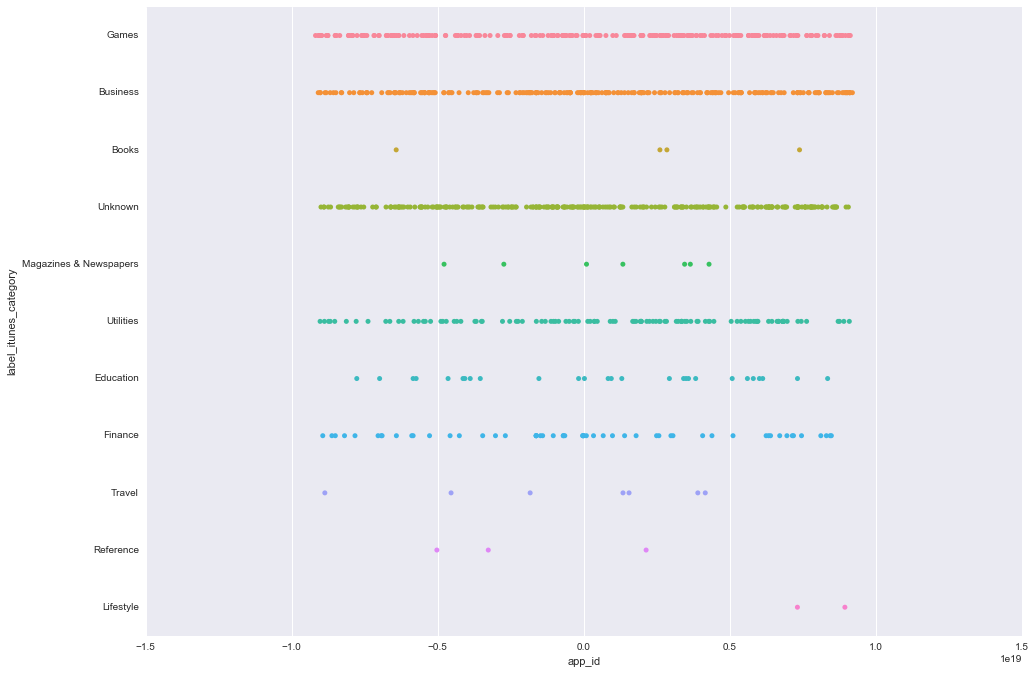

In [19]:
# sns.countplot(x="label_itunes_category", data=label_categories, palette="Greens_d");
app_labels_pandas = app_labels.toPandas()
app_labels_pandas = app_labels_pandas.sample(1000, replace=True)

a4_dims = (15.7, 11.27)
# df = mylib.load_data()
fig, ax = pyplot.subplots(figsize=a4_dims)
sns.stripplot(x="app_id", y="label_itunes_category", data=app_labels_pandas);

In [20]:
app_cat_freq = app_labels.groupby("category") \
                         .agg(count(lit(1)) \
                         .alias("category_freq")) \
                         .sort(col("category_freq").desc())
app_cat_freq.show(100)

+--------------------+-------------+
|            category|category_freq|
+--------------------+-------------+
|        Industry tag|        56902|
|        Custom label|        53936|
|             Tencent|        49320|
|                game|        48707|
|Property Industry...|        45697|
|              1 free|        19083|
|          Services 1|        11840|
|Property Industry...|         9955|
|         Relatives 1|         9027|
|  Irritation / Fun 1|         8831|
|           Cards RPG|         7375|
|Casual puzzle cat...|         7052|
|Personal Effectiv...|         5910|
|                ARPG|         5306|
|    Chess categories|         5135|
|The elimination o...|         5124|
|      And the Church|         4619|
|               round|         3608|
|             unknown|         2754|
|                free|         2744|
|Personal Effectiv...|         2588|
| Parkour avoid class|         2496|
|       Low liquidity|         2471|
|Shootout Shooting...|         2353|
|

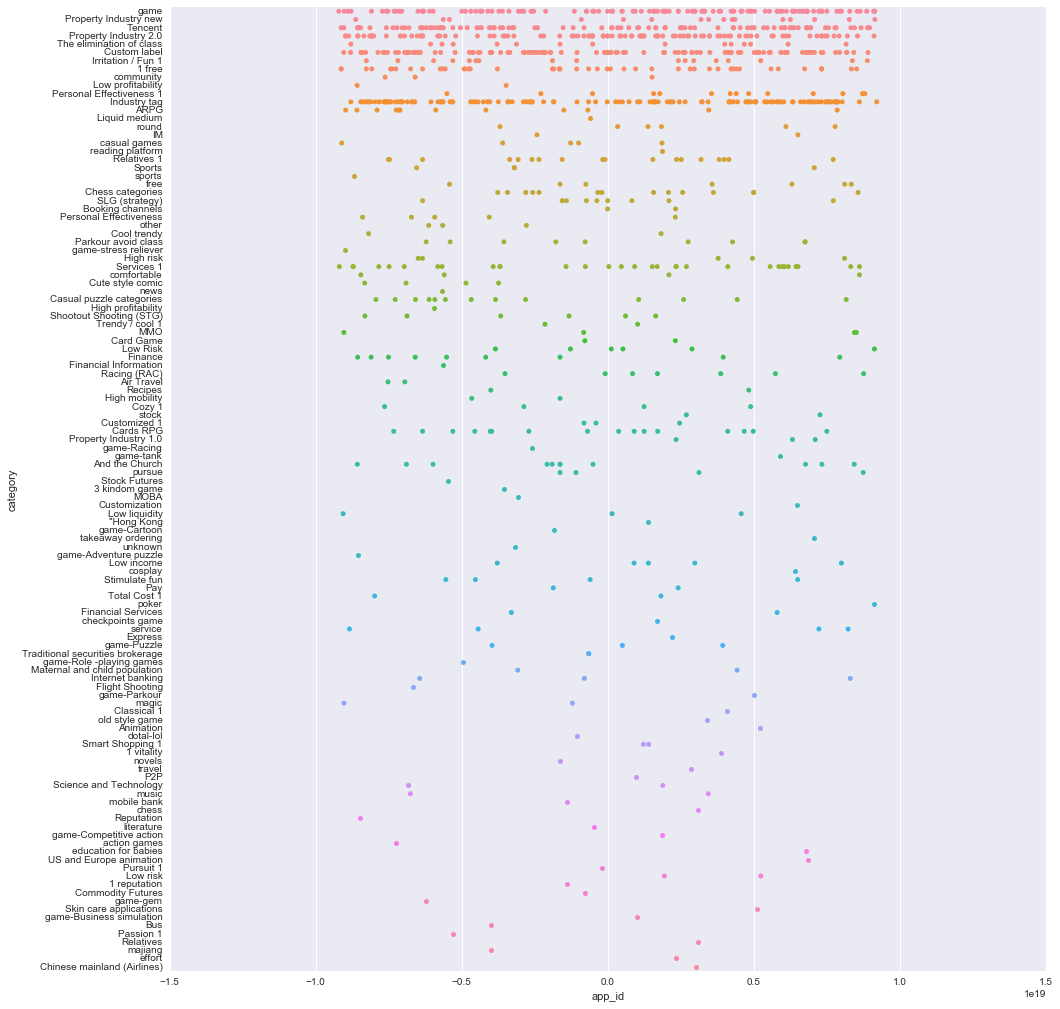

In [21]:
# sns.countplot(x="label_itunes_category", data=label_categories, palette="Greens_d");
app_labels_pandas = app_labels.toPandas()
app_labels_pandas = app_labels_pandas.sample(1000, replace=True)

a4_dims = (15.7, 17.27)
# df = mylib.load_data()
fig, ax = pyplot.subplots(figsize=a4_dims)
sns.stripplot(x="app_id", y="category", data=app_labels_pandas);

# Mobile Users

In [22]:
app_events_itunes_freq = app_events.groupby("label_itunes_category") \
                         .agg(count(lit(1)) \
                         .alias("category_freq")) \
                         .sort(col("category_freq").desc())
print app_events_itunes_freq.show(100)

+---------------------+-------------+
|label_itunes_category|category_freq|
+---------------------+-------------+
|              Finance|     67424384|
|              Unknown|     55944992|
|             Business|     55631558|
|            Reference|      4541351|
|            Lifestyle|      3947833|
|               Travel|      3424509|
|             Shopping|      3271806|
|        Entertainment|      2648966|
|                 null|      2503657|
|            Education|      2083171|
|            Utilities|      2057345|
|                Games|      1713995|
|                Books|      1580956|
|                Music|       851512|
|    Social Networking|       631709|
|                 News|       587685|
|           Navigation|       560625|
|     Health & Fitness|       546343|
|        Photo & Video|       418271|
|              Medical|       353594|
| Magazines & Newsp...|       337912|
|         Food & Drink|        53399|
|              Weather|         4991|
+-----------

In [25]:
# sns.countplot(x="label_itunes_category", data=label_categories, palette="Greens_d");
app_events_pandas = app_events.toPandas()
app_events_pandas = app_events_pandas.sample(100, replace=True)

a4_dims = (15.7, 11.27)
# df = mylib.load_data()
fig, ax = pyplot.subplots(figsize=a4_dims)
sns.stripplot(x="event_id", y="label_itunes_category", data=app_events_pandas)

Py4JJavaError: An error occurred while calling o206.collectToPython.
: org.apache.spark.SparkException: Job aborted due to stage failure: Total size of serialized results of 41 tasks (1042.4 MB) is bigger than spark.driver.maxResultSize (1024.0 MB)
	at org.apache.spark.scheduler.DAGScheduler.org$apache$spark$scheduler$DAGScheduler$$failJobAndIndependentStages(DAGScheduler.scala:1499)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1487)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1486)
	at scala.collection.mutable.ResizableArray$class.foreach(ResizableArray.scala:59)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:48)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:1486)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:814)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:814)
	at scala.Option.foreach(Option.scala:257)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:814)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:1714)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:1669)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:1658)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:48)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:630)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2022)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2043)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2062)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2087)
	at org.apache.spark.rdd.RDD$$anonfun$collect$1.apply(RDD.scala:936)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:362)
	at org.apache.spark.rdd.RDD.collect(RDD.scala:935)
	at org.apache.spark.sql.execution.SparkPlan.executeCollect(SparkPlan.scala:278)
	at org.apache.spark.sql.Dataset$$anonfun$collectToPython$1.apply$mcI$sp(Dataset.scala:2803)
	at org.apache.spark.sql.Dataset$$anonfun$collectToPython$1.apply(Dataset.scala:2800)
	at org.apache.spark.sql.Dataset$$anonfun$collectToPython$1.apply(Dataset.scala:2800)
	at org.apache.spark.sql.execution.SQLExecution$.withNewExecutionId(SQLExecution.scala:65)
	at org.apache.spark.sql.Dataset.withNewExecutionId(Dataset.scala:2823)
	at org.apache.spark.sql.Dataset.collectToPython(Dataset.scala:2800)
	at sun.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at sun.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:280)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:214)
	at java.lang.Thread.run(Thread.java:745)


# Modeling

- https://github.com/bennyaustin/kaggle/tree/master/TalkingData
- https://bennyaustin.wordpress.com/2016/10/08/kaggle-talkingdata/
- https://spark.apache.org/docs/2.2.0/mllib-ensembles.html
- http://xgboost.readthedocs.io/en/latest/build.html
- https://pdfs.semanticscholar.org/8702/e712ede10ada8d076dd5261c0abfc921e78a.pdf

# Separating the variables to input in csr_matrix function so it can be readable.

In [ ]:

train_2_shape = (train_2.count(), len(train_2.columns))
test_2_shape = (test_2.count(), len(test_2.columns))
a = np.ones(train_2_shape[0])
b = np.arange(train_2_shape[0])
c = phone.select("phone_brand_index")
d = train_2_shape[0]
e = phone.select("phone_brand").distinct().count()

f = np.ones(test_2_shape[0])
g = np.arange(test_2_shape[0])
h = phone.select("phone_brand_index")
i = test_2_shape[0]
j = e

k = a
l = b
m = train_2.select("device_model_index")
n = d
o = phone.select("device_model").distinct().count()

p = f
q = g
r = test_2.select("device_model_index")
s = i
t = o

# # Create the sparse matrices for brand and model for both train and test dfs

# train_brand = csr_matrix((a, (b, c)), shape=(d,e))
# test_brand = csr_matrix((f,(g, h)), shape=(i,j))
# train_model = csr_matrix((k, (l, m)), shape=(n,o))
# test_model = csr_matrix((p, (q, r)), shape=(s,t))

# # Under impression that indices are not matching, aka, 1st row of csr matrices are empty when it shou